In [3]:
import numpy as np
import matplotlib.pylab as plt
import Vol6Utl as utl

## SGD

In [4]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
    
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

## Momentum

In [1]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

## AdaGrad

In [2]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
    
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.h[key] += grads[key]*grads[key]
            params[key] -= self.lr * grads[key]/(np.sqrt(self.h[key]) + 1e-7)

## weight_init_activation_histogram

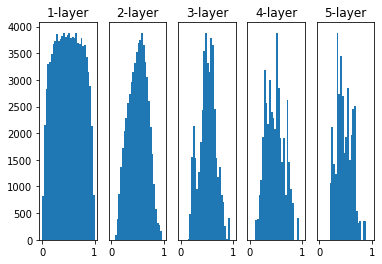

In [8]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000個のデータ
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここにアクティベーションの結果を格納する

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 初期値の値をいろいろ変えて実験しよう！
    #w = np.random.randn(node_num, node_num) * 1
    #w = np.random.randn(node_num, node_num) * 0.01
    #w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 活性化関数の種類も変えて実験しよう！
    z = sigmoid(a)
    #z = ReLU(a)
    #z = tanh(a)

    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()
